ThinCurr Python Example: Using HODLR approximation {#doc_tCurr_hodlr}
==========
In this example we demonstrate how to compute eigenvalues/eigenvectors and run a time-domain simulation for a large ThinCurr model using HODLR matrix compression.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import Mirnov, save_sensors
from OpenFUSIONToolkit.util import mu0
from OpenFUSIONToolkit.io import histfile

## Compute eigenvalues

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. As this is a larger model, we use `nthreads=4` to increase the number of cores used for the calculation. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
tw_torus = ThinCurr(nthreads=4)
tw_torus.setup_model(mesh_file='thincurr_ex-ports.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_error_reason
Revision id:          eabf63f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =       26500
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =        22580
  # of edges     =        67150
  # of cells     =        44560
  # of holes     =           11
  # of Vcoils    =            0
  # of closures  =            0
  # of Icoils    =            1

  Building holes

  Loading region resi

In [4]:
sensors = []
for i, theta in enumerate(np.linspace(0.0,2.0*np.pi/20.0,3)):
    sensors.append(Mirnov(1.6*np.r_[np.cos(theta),np.sin(theta),0.0], np.r_[0.0,0.0,1.0], 'Bz_{0}'.format(i+1)))
save_sensors(sensors)
Msensor, Msc, sensor_obj = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           3
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Compute inductance and resistivity matrices
With the model setup, we can now compute the self-inductance matrix using HODLR. When HODLR is used the result is a pointer to the Fortran operator, which is stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat_hodlr "tw_torus.Lmat_hodlr". As in any other case, by default, the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** Even though HODLR should significantly accelerate the construction of the self-inductance matrix (see \ref doc_thincurr_ex4 for more information) this process may still take some time to complete.

**Note:** The non-zero savings achieved by HODLR compression is reported after the operator is built. Where in this case only 6% of the original memory is needed resulting in a reduction from > 3 GB to ~ 230 MB (over 10x smaller)!

In [5]:
Mc = tw_torus.compute_Mcoil()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix


In [6]:
tw_torus.compute_Lmat(use_hodlr=True,cache_file='HOLDR_L.save')

 Partitioning grid for block low rank compressed operators
   nBlocks =                  32
   Avg block size =          686
   # of SVD =                167
   # of ACA =                161

 Building block low rank inductance operator
   Building hole and Vcoil columns
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   6.1%  ( 2.94E+07/ 4.82E+08)
     Time =  1m 49s      
   Saving HODLR matrix to file: HOLDR_L.save


In [7]:
tw_torus.compute_Rmat()

 Building resistivity matrix


### Compute eigenvalues/eigenvectors for the plate model
With $\textrm{L}$ and $\textrm{R}$ matrices we can now compute the eigenvalues and eigenvectors of the system $\textrm{L} I = \lambda \textrm{R} I$, where the eigenvalues $\lambda = \tau_{L/R}$ are the decay time-constants of the current distribution corresponding to each eigenvector.

In [8]:
eig_vals, eig_vecs = tw_torus.get_eigs(100,False)

 Starting eigenvalue solve
   Time =    3.1392110000000000     
 Eigenvalues
      3.8803528754750460E-002
      2.3122408284713861E-002
      2.3121318923583829E-002
      2.1444714035339145E-002
      2.0605569624013463E-002


### Save data for plotting
The resulting currents can be saved for plotting using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.save_current "tw_torus.save_current()". Here we save each of the five eigenvectors for visualization. Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_torus.build_XDMF()" to generate the [XDMF descriptor files](https://www.xdmf.org/index.php/XDMF_Model_and_Format) for plotting with VisIt of Paraview.

In [9]:
tw_torus.save_current(eig_vecs[0,:],'J_01')
tw_torus.save_current(eig_vecs[1,:],'J_02')
tw_torus.save_current(eig_vecs[2,:],'J_03')
tw_torus.save_current(eig_vecs[3,:],'J_04')
plot_data = tw_torus.build_XDMF()

Removing old Xdmf files
  Removed 23 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: ThinCurr
    Found Mesh: icoils
    Found Mesh: smesh


## Plot current fields using pyvista
For demonstration purposes we now plot the first eigenvector using [pyvista](https://pyvista.org/).

### Load data from plot files
To plot the fields we must load in the mesh from the plot files.

**Note:** In the future this will be handled by dedicated python functions, but we show it here at the moment for demonstration purposes.

In [10]:
grid = plot_data['ThinCurr']['smesh'].get_pyvista_grid()
J_01 = tw_torus.reconstruct_current(eig_vecs[0,:],centering='vertex')

### Generate vector plot
Finally we plot the current vectors on the plate showing the longest-lived eddy current structure, which corresponds to a large circulation on the plate.

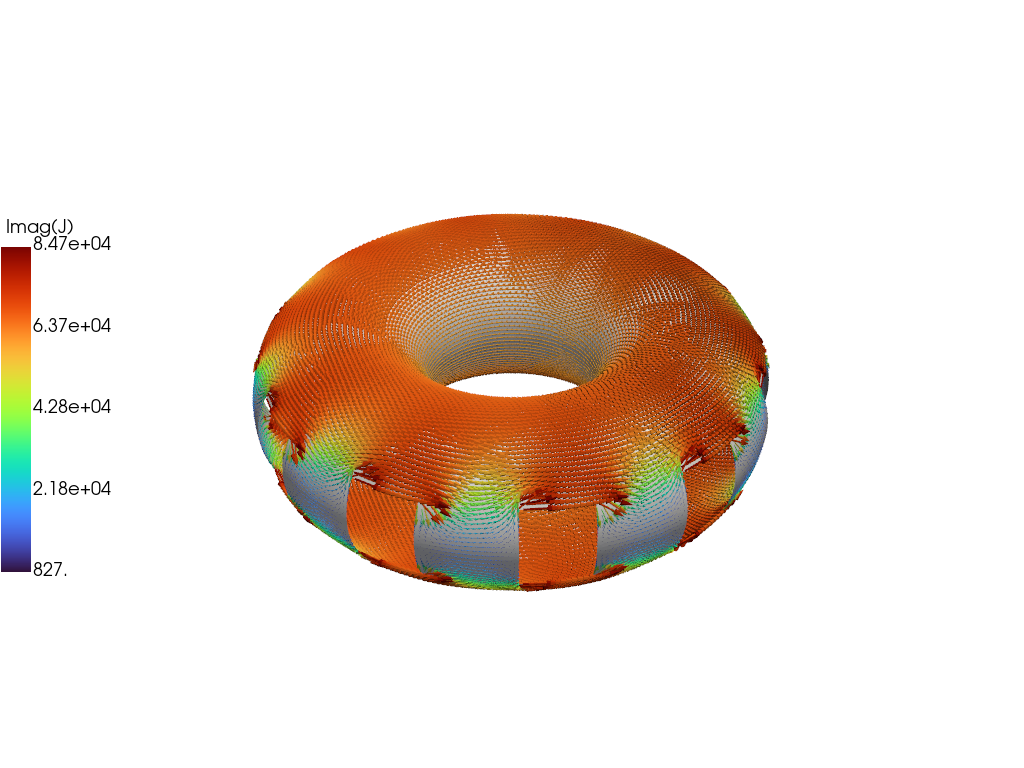

In [11]:
p = pyvista.Plotter()
grid["vectors"] = J_01
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(J_01,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()

## Run time-domain simulation

In [12]:
dt = 2.E-4
nsteps = 200
coil_currs = np.array([
    [0.0, 1.E6],
    [4.E-3, 0.0],
    [1.0, 0.0]
])
tw_torus.run_td(dt,nsteps,status_freq=10,coil_currs=coil_currs,sensor_obj=sensor_obj)


 Starting simulation
 Timestep           10   2.00000009E-03   22.7324581              32
 Timestep           20   4.00000019E-03   44.1192436              18
 Timestep           30   6.00000005E-03   42.2026978              32
 Timestep           40   8.00000038E-03   39.9049377              32
 Timestep           50   9.99999978E-03   37.7692757              32
 Timestep           60   1.20000001E-02   35.7698631              32
 Timestep           70   1.40000004E-02   33.8907852              32
 Timestep           80   1.60000008E-02   32.1206093              32
 Timestep           90   1.79999992E-02   30.4503784              32
 Timestep          100   1.99999996E-02   28.8726788              32
 Timestep          110   2.19999999E-02   27.3811493              32
 Timestep          120   2.40000002E-02   25.9701900              32
 Timestep          130   2.60000005E-02   24.6347961              32
 Timestep          140   2.80000009E-02   23.3704281              32
 Timestep   

### Generate plot files from run

In [13]:
_, Bc = tw_torus.compute_Bmat(cache_file='HODLR_B.save')

 Building block low rank magnetic field operator
   Building hole and Vcoil columns
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   7.1%  ( 1.06E+08/ 1.49E+09)
     Time =  3m 29s      
   Saving HODLR matrix from file: HODLR_B.save


In [14]:
tw_torus.plot_td(nsteps,compute_B=True,sensor_obj=sensor_obj)
_ = tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
  Removed 2 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: ThinCurr
    Found Mesh: icoils
    Found Mesh: smesh


### Load sensor signals from time-domain run

In [15]:
hist_file = histfile('floops.hist')
print(hist_file)


OFT History file: floops.hist
  Number of fields = 4
  Number of entries = 201

  Fields:
    time: Simulation time [s] (d1)
    Bz_1: No description (d1)
    Bz_2: No description (d1)
    Bz_3: No description (d1)

